# Notebook to plot exit wave of material from the C2DB

Plots a figure showing a system, the three simulated images of it, the ground truth exit wave, the exit wave reconstructed by the neural network, and the difference.

The plots consist of:
- Two rows, one corresponding to the real part of the wavefunction, the second corresponding to the imaginary part of the wavefunction (except for the first two columns)
- Two columns containing the structure and the simulated images
- One row containing the ground truth for the network
- One row containing the prediction made by the network, on the grounds of the simulated image
- One row containing the differences between the ground truth and the predictions.  An inset shows the point where the difference is largest

(The plots are on identical scales)

## Run this to import the needed packages and functions

In [1]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
import matplotlib.ticker
from glob import glob
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

#from temnn.data.dataset import DataEntry,DataSet
from temnn.data.mods import local_normalize
from stm.feature.peaks import find_local_peaks, refine_peaks

from scipy.ndimage.filters import maximum_filter
from skimage.morphology import disk
from scipy.spatial import cKDTree as KDTree
import sys
import os
import json
from collections import deque
from multiprocessing import Pool
import ase.io
import skimage.io
from PIL import Image
import pandas as pd

num_gpus = 1
batch_size = 1 * num_gpus

/home/modules/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/site-packages/cryptography/hazmat/bindings/openssl/binding.py:173: CryptographyDeprecationWarning: OpenSSL version 1.0.2 is no longer supported by the OpenSSL project, please upgrade. The next version of cryptography will drop support for it.
  warnings.warn(


# Choose the dataset you want to draw images from

In [2]:
# Uncomment the dataset you want

data_dir = "../workflow/simulation_data/c2db_15pm-test/" 

# Path to the trained network
folder = '../workflow/trained_networks/c2db_15pm'

## Load model


In [3]:

model_path = os.path.join(folder, 'model-0')
#model_path = os.path.join(folder, 'checkpoint-0135')

# load the network
print('Loading model', model_path)
model = keras.models.load_model(model_path)
#model.summary(line_length=150)


Loading model ../workflow/trained_networks/c2db_15pm/model-0


## Select an image

We load the RMSD's of all the images so we can choose the median.

In [4]:
histdata = np.load(os.path.join(folder, 'histogram-epoch-model-0.npz'))
rmse = histdata['rel_rmse']
order = np.argsort(rmse)
median = len(order) // 2
print(median)
for i in (0, median, -2):
    j = order[i]
    print(i,j)
    print(rmse[j:j+1])

1060
0 1376
[0.12132472]
1060 1132
[0.31634764]
-2 1063
[2.29219961]


## Select and load image


In [5]:
number = order[median]
#number = 865
imagenumber = '000_{:04d}'.format(number)
print(number, imagenumber)
tmp = np.load(os.path.join(data_dir, 'images_labels', 'image_label_'+imagenumber+'.npz'))
image = tmp['image']
wave = tmp['label']

# Load parameters
parameters = json.load(open(os.path.join(data_dir, 'parameters.json')))
imageparameters = json.load(open(os.path.join(data_dir, 'tem_params', 'parameters_'+imagenumber)))
image_size = parameters['image_size']
sampling = imageparameters['sampling']
normalizedistance = parameters['normalizedistance'] / sampling
defocus = imageparameters['defocus']

# Read the atoms
atoms = ase.io.read(os.path.join(data_dir, 'model', 'model_'+imagenumber.split('_')[1]+'.traj'))
formula = atoms.info['prototype']
full_formula = atoms.get_chemical_formula()
#print(formula)
print(full_formula)

# Load the image, if present
raytracedimagefile = 'MoS2_unsup_raytrace_'+imagenumber.split('_')[1]
if not os.path.exists(raytracedimagefile+'.png'):
    print("Raytracing!")
    raytraced = None
    atoms.rotate(90, 'z')
    atoms.rotate(180, 'x')
    atoms.center(vacuum=1.0)
    ase.io.write(raytracedimagefile+'.pov', 
                 atoms, povray_settings=dict(celllinewidth=0.0, canvas_width=1000))
    os.system(f'module load POV-Ray; povray {raytracedimagefile}.ini')
raytraced = skimage.io.imread(raytracedimagefile+'.png')
# Cut the black border
raytraced = raytraced[5:-5,5:-5]
# Now crop the image, removing background except for a five pixels margin
bbox = Image.fromarray(raytraced).getbbox()
print("Old bbox:", bbox)
sh = raytraced.shape
print("Shape:", sh)
bbox = (max(0, bbox[0]-1), max(0, bbox[1]-1), min(sh[1], bbox[2]+1), min(sh[0], bbox[3]+1))
print("New bbox:", bbox)
raytraced = raytraced[bbox[1]:bbox[3],bbox[0]:bbox[2]]
# Some images are flipped - needs to be done manually
raytraced = raytraced[:,::-1]

    
def rmse(a):
    return np.sqrt(np.mean(a*a))

print("Normalizing")
normimage = local_normalize(image.copy(), normalizedistance, normalizedistance)
print("Predicting")
print(wave.shape, wave.dtype, image.shape, image.dtype) 
predictions = model.predict(normimage)
print(predictions.shape, predictions.dtype)
diff = np.abs(wave - predictions)
print("RMSE:  Re = {}    Im = {}".format(rmse(diff[...,0]), rmse(diff[...,1])))
diff = abs(diff)
print("Worst difference:", diff.max())
print("   at position", np.unravel_index(diff.argmax(), diff.shape), "of", diff.shape)

# Scales for the plots
maxval = max(wave[0,:,:,:].max(), predictions[0,:,:,:].max())
minval = min(wave[0,:,:,:].min(), predictions[0,:,:,:].min())
print("Values in [{}, {}]".format(minval, maxval))
maxval = symval = max(-minval, maxval)
maxval = 1.08
minval = -maxval

# Find the worst position at least 20 pixels from the edge
edge = 20
#worstpos = np.unravel_index(np.abs(wave - predictions).argmax(), wave.shape)[1:3]
err = np.abs(wave - predictions)[0,edge:-edge,edge:-edge,:]
worstpos = np.unravel_index(err.argmax(), err.shape)[:2]
worstpos = np.array(worstpos) + edge
print("Worst postion", worstpos)
center = np.array(wave.shape[1:3]) // 2


1132 000_1132
Cl272Co274
Old bbox: (18, 18, 972, 976)
Shape: (994, 990, 4)
New bbox: (17, 17, 973, 977)
Normalizing
Predicting
(1, 640, 640, 2) float32 (1, 640, 640, 3) float32
(1, 640, 640, 2) float32
RMSE:  Re = 0.017415709793567657    Im = 0.03279196098446846
Worst difference: 0.4052916
   at position (0, 235, 195, 1) of (1, 640, 640, 2)
Values in [-0.17545634508132935, 0.893243134021759]
Worst postion [235 195]


In [6]:
image_size

[640, 640]

## Make the plots

In [7]:
rmse_re = np.sqrt(np.mean((predictions - wave)[...,0]**2))
rmse_im = np.sqrt(np.mean((predictions - wave)[...,1]**2))
rmse = np.sqrt(np.mean((predictions - wave)**2))

print("RMSE:", rmse_re, rmse_im, rmse)

RMSE: 0.01741571 0.03279196 0.026254712


c2db_1132_Cl2Co2_RMSE0.0263


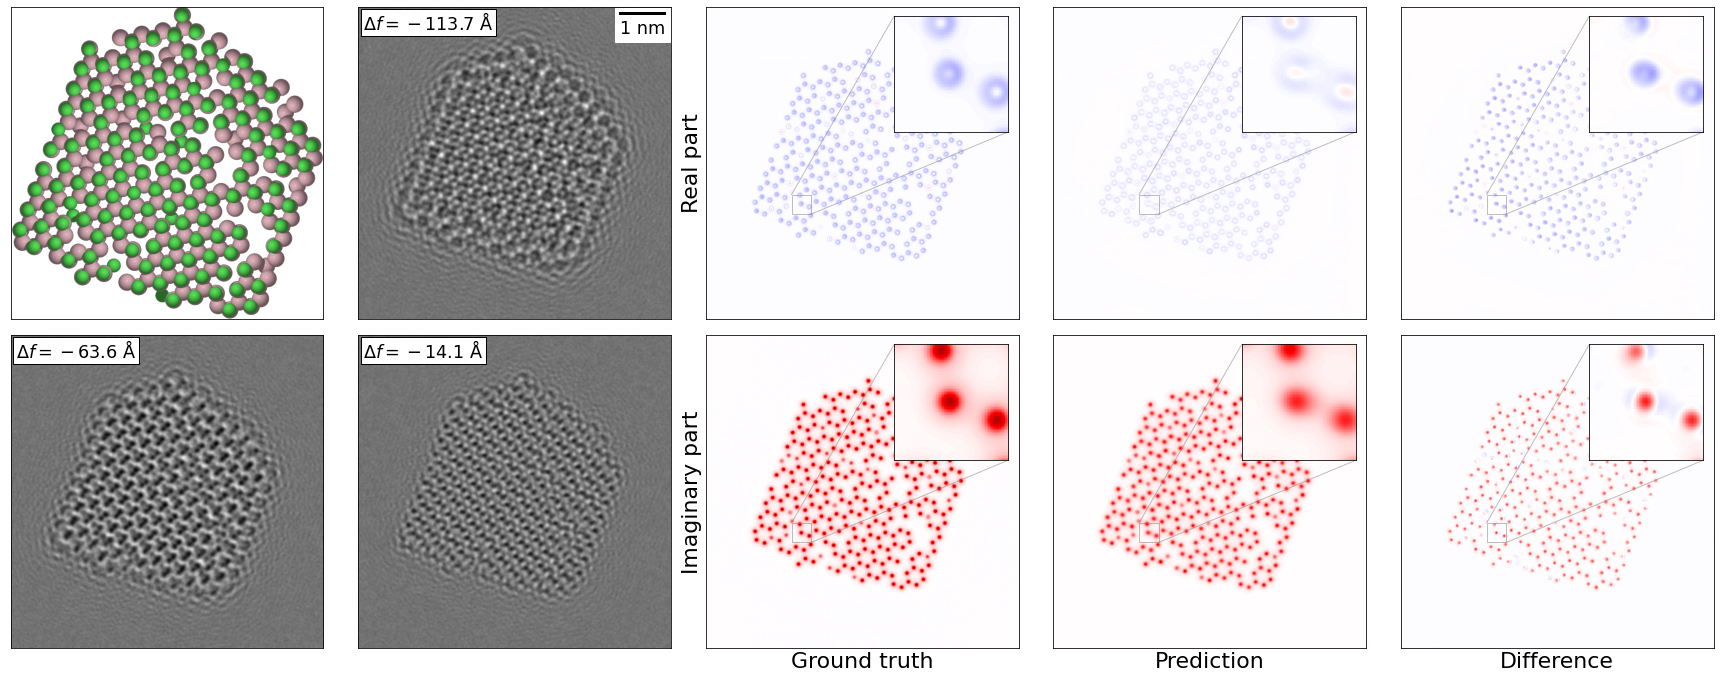

In [8]:
# Actual plotting - wide version

usecolorbar = False
cmap = 'seismic'
zoom = True
textsize = 22
if zoom:
    def myplot(ax, data, **kwargs):
        image = ax.imshow(data, origin='lower', **kwargs)
        ax.set_xticks([])
        ax.set_yticks([])
        # Make insert, depending on where the maximum is
        d = 0.03
        s = 0.4
        x = worstpos - center
        #print(worstpos, center, x)
        if x[0] < 0 and x[1] < 0:
            pos = [1 - s, 1 - s]
        elif x[0] >= 0 and x[1] < 0:
            pos = [1 - s, d]
        elif x[0] < 0 and x[1] >= 0:
            pos = [d, 1 - s]
        else:
            pos = [d, d]
        ins = ax.inset_axes(pos + [s - d, s - d])
        ins.imshow(data, origin='lower', **kwargs)
        ins.set_xlim(worstpos[1] - 20, worstpos[1] + 20)
        ins.set_ylim(worstpos[0] - 20, worstpos[0] + 20)
        ins.set_xticks([])
        ins.set_yticks([])
        ax.indicate_inset_zoom(ins)
        return image
else:
    def myplot(ax, data, **kwargs):
        image = ax.imshow(data, **kwargs)
        ax.set_xticks([])
        ax.set_yticks([])
        return image
        
if usecolorbar:
    fig = plt.figure(figsize=(24,9.6))
    gs = GridSpec(2, 6, width_ratios = [1, 1, 1, 1, 1, 0.05])
    ax = [ [fig.add_subplot(gs[r,c]) for c in range(5)] for r in range(2) ]

    # Space for colorbar
    subgs = gs[:,-1].subgridspec(4, 1)
    cbar_ax = fig.add_subplot(subgs[1:-1,0])
else:
    fig, ax = plt.subplots(2,5,figsize=(24,9.6))

# Plot the structure.  It must be padded to be square
xsize, ysize, _ = raytraced.shape
if xsize > ysize:
    dy1 = (xsize - ysize) // 2
    dy2 = xsize - ysize - dy1
    raytraced_pad = np.pad(raytraced, ((0, 0), (dy1, dy2), (0,0)))
elif ysize > xsize:
    dx1 = (ysize - xsize) // 2
    dx2 = ysize - xsize - dx1
    raytraced_pad = np.pad(raytraced, ((dx1, dx2), (0, 0), (0,0)))
xsize, ysize, _ = raytraced_pad.shape
assert xsize == ysize

ax[0][0].imshow(raytraced_pad, origin='lower')
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
  
# Find common minimal and maximal values for the three images
imgmin = min([image[0,:,:,i].min() for i in range(3)])
imgmax = max([image[0,:,:,i].max() for i in range(3)])
# The three images
for i, j, k in ((0, 0, 1), (1, 1, 0), (2, 1, 1)):
    ax[j][k].imshow(image[0,:,:,i], origin='lower', cmap='gray',
                    vmin=imgmin, vmax=imgmax)
    ax[j][k].set_xticks([])
    ax[j][k].set_yticks([])
    ax[j][k].text(10, image_size[1] - 10, 
                  f'$\Delta f = {defocus[i]:.1f}$ Å',
                  ha='left', va='top',
                  bbox=dict(fc='white', ec=None, boxstyle='square,pad=0.15'),
                  fontsize = 0.8 * textsize)
#                  bbox=dict(fill=True, facecolor='white'))

#ax[0][0].set_ylabel('Images', fontsize=textsize)
#ax[0][1].set_title('{}  ({})'.format(formula, full_formula), fontsize=30)
#ax[0][1].set_title('MoS2', fontsize=30)

for i in range(2):
    lastwave = myplot(ax[i][2], wave[0,:,:,i], 
           cmap=cmap, vmax = maxval, vmin = minval)
    myplot(ax[i][3], predictions[0,:,:,i], 
           cmap=cmap, vmax = maxval, vmin = minval)
    myplot(ax[i][4], wave[0,:,:,i]-predictions[0,:,:,i], 
           cmap=cmap, vmax = symval, vmin = -symval)
ax[0][2].set_ylabel('Real part', fontsize=textsize)
ax[1][2].set_ylabel('Imaginary part', fontsize=textsize)
ax[1][2].set_xlabel('Ground truth', fontsize=textsize)
ax[1][3].set_xlabel('Prediction', fontsize=textsize)
ax[1][4].set_xlabel('Difference', fontsize=textsize)

# Make colorbar
if usecolorbar:
    fig.colorbar(lastwave, 
                 cax=cbar_ax,
                 ticks=matplotlib.ticker.MultipleLocator(0.2))
    cbar_ax.tick_params(labelsize=0.8*textsize)

# Place a scalebar
scalebar = ScaleBar(0.1*sampling, 'nm', fixed_value=1, pad=0.4, 
                    font_properties={'size': 0.8 * textsize})
ax[0][1].add_artist(scalebar)
plt.tight_layout()
filename = f"c2db_{number:04d}_{formula}_RMSE{rmse:.4f}"
print(filename)
plt.savefig(filename+'_wide.png', dpi=300)
None  

### Calculate RMSE for figure text.

In [9]:
rmse = np.sqrt( ((wave[0]-predictions[0])**2).mean() )
print("RMSE:", rmse)

RMSE: 0.026254712


### Peak finding¶

In [10]:
peaks = find_local_peaks(predictions[0,:,:,1], min_distance=10, 
                         threshold=0.50, exclude_border=10,
                         exclude_adjacent=True).astype(int)
peaks = refine_peaks(predictions[0,:,:,1], peaks, 7, 'polynomial')
wavepeaks = find_local_peaks(wave[0,:,:,1], min_distance=10, 
                         threshold=0.50, exclude_border=10,
                         exclude_adjacent=True).astype(int)
wavepeaks = refine_peaks(wave[0,:,:,1], wavepeaks, 7, 'polynomial')

print(len(peaks), len(wavepeaks))

262 270


In [11]:
if len(peaks) <= len(wavepeaks):
    p1 = peaks
    p2 = wavepeaks
else:
    p1 = wavepeaks
    p2 = peaks
kdt = KDTree(p2)
hits = kdt.query_ball_point(p1, 5)
displacements = []
for i, h in enumerate(hits):
    if len(h) < 1:
        continue
    xy = p1[i]
    hitxy = p2[h[0]]
    displacements.append(xy - hitxy)
displacements = np.array(displacements)

In [12]:
np.linalg.norm(displacements, axis=1).max()

0.766089111742574

In [13]:
np.linalg.norm(displacements, axis=1).max() * sampling

0.07968851865350064